In [1]:
#https://mlrose.readthedocs.io/en/stable/source/algorithms.html

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
import time
import mlrose

# Set random seed 
import random
random.seed(27)

# Plot inline
%matplotlib inline

Using TensorFlow backend.
C:\Users\tg784d\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Part 2
# Dataset 1: Online News Popularity
# Source: https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity

# Load dataset
raw = pd.read_csv('OnlineNewsPopularity.csv', header = 0)
# Remove leading and trailing white space in column headers
raw = raw.rename(columns=lambda x: x.strip())

# Remove irrelevant columns (e.g. url)
df = raw.drop(['url'], axis = 1)

# Create a class of data to describe if shares above/below 1400
# This transforms the problem from a continuous state to a binary state
df['class'] = np.where(df['shares'] > 1400, 1, 0)

# Drop the 'shares' data
df = df.drop(['shares'], axis = 1)

# Sample smaller set
df = df.sample(n=5000)

# Feature selection
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
# https://people.duke.edu/~rnau/rsquared.htm

# Correlation Analysis
df_corr = abs(df.corr())
df_corr = df_corr['class']
df_corr = pd.DataFrame(df_corr.values, df.columns).reset_index()
df_corr.columns = ['Feature', 'Corr']
df_corr = df_corr[df_corr['Corr'] > 0.06]
df_corr = df_corr.sort_values(by='Corr', ascending=False)[1:]
df_corr = df_corr.head(10)
#df_corr

# Univariate Analysis
y = df['class']
X = df.drop(['class'], axis=1)

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores = featureScores.sort_values(by='Score', ascending=False).head(10)
#featureScores

# Determine overlap between features
idx1 = pd.Index(df_corr['Feature'])
idx2 = pd.Index(featureScores['Specs'])
features_list = idx1.intersection(idx2)
#features_list

# Create heatmap to show overlap features
X1 = X[features_list]
#plt.subplots(1,1,figsize=(18,8))
#sns.heatmap(X1.corr(),annot=True,cmap="RdYlGn")

# Remove highly correlated (redundant) features to maximize information gain
features_to_remove = ['LDA_02','weekday_is_saturday']
lst = list(features_list.values)
selected_features = [e for e in lst if e not in features_to_remove]

#Split the dataset between the features (X) and target variable (y)
from sklearn.preprocessing import MinMaxScaler
X = X[selected_features]

#scaling = MinMaxScaler(feature_range=(-1,1)).fit(X)
#X = scaling.transform(X)

y = y

#Train, Test, Split the dataset to get the training data with a test size of 0.3
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)


# Normalize feature data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [3]:
# Learning Curve using optimized hyperparameters
train_acc = []
test_acc = []
train_time = []
test_time = []

# Create Model Architecture
model = Sequential()
model.add(Dense(96, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dense(32, init='uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
sgd = optimizers.SGD(lr=0.25, momentum=0.25, nesterov=False)
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])


# Fit the model and test
n_epochs = range(1,7502,750)

for n in n_epochs:
    train = time.time()
    history = model.fit(X_train, y_train, epochs=n, batch_size=128, verbose = 0)
    train_epoch = time.time() - train 
    test = time.time()
    results = model.evaluate(X_test, y_test, batch_size=128, verbose = 0)
    test_epoch = time.time() - test
    #print(results[1])
    
    # Append data
    train_avg = np.mean(history.history['acc'])
    test_avg = np.mean(results[1])
    train_acc.append(train_avg)
    test_acc.append(test_avg)
    train_time.append(train_epoch)
    test_time.append(test_epoch)
    print("Completed %s iterations!"%str(n))
#history_adadelta = model_adadelta.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=10)

W1013 16:03:40.549990 20324 deprecation_wrapper.py:119] From C:\Users\tg784d\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\Users\tg784d\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(96, input_dim=8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
W1013 16:03:40.564027 20324 deprecation_wrapper.py:119] From C:\Users\tg784d\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1013 16:03:40.566033 20324 deprecation_wrapper.py:119] From C:\Users\tg784d\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

C:\Users\tg784d\anaconda3\lib\site-packages\ipykernel_launcher.py:10:

Completed 1 iterations!
Completed 751 iterations!
Completed 1501 iterations!
Completed 2251 iterations!
Completed 3001 iterations!
Completed 3751 iterations!
Completed 4501 iterations!
Completed 5251 iterations!
Completed 6001 iterations!
Completed 6751 iterations!
Completed 7501 iterations!


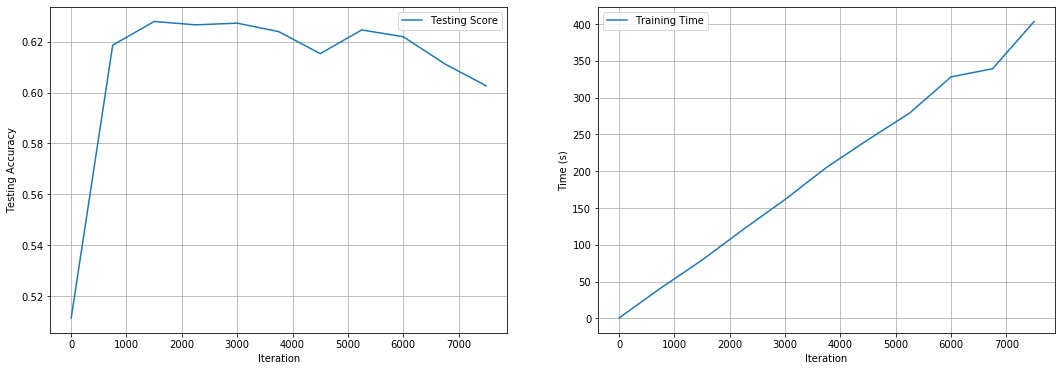

In [5]:
# summarize history for accuracy
fig = plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
#plt.plot(n_epochs, train_acc, label = 'Training Score')
plt.plot(n_epochs, test_acc, label = 'Testing Score')
plt.ylabel('Testing Accuracy')
plt.xlabel('Iteration')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(n_epochs, train_time, label = 'Training Time')
#plt.plot(n_epochs, test_time, label = 'Testing Time')
plt.ylabel('Time (s)')
plt.xlabel('Iteration')
plt.grid(True)
plt.legend()

In [7]:
# Initialize neural network object and fit object 
# https://buildmedia.readthedocs.org/media/pdf/mlrose/stable/mlrose.pdf
# Page 21

nn_Data = []
algs = ['random_hill_climb', 'genetic_alg', 'simulated_annealing']
#algs = ['random_hill_climb']
#iters = [1, 5, 10]
iters = range(1,7502, 250)
for alg in algs:
    for n in iters:
        start = time.time()
        nn_model = mlrose.NeuralNetwork(algorithm = alg, bias = True,
                                   learning_rate = 0.01, early_stopping = False, 
                                   clip_max = 5, max_attempts = 100,
                                   max_iters = n, random_state = 3)
        nn_model.fit(X_train, y_train)


        # Predict labels for train set and assess accuracy
        y_train_pred = nn_model.predict(X_train)
        y_train_accuracy = accuracy_score(y_train, y_train_pred)
        y_train_mse = mean_squared_error(y_train, y_train_pred)

        # Predict labels for test set and assess accuracy
        y_test_pred = nn_model.predict(X_test)
        y_test_accuracy = accuracy_score(y_test, y_test_pred)
        y_test_mse = mean_squared_error(y_test, y_test_pred)
        end = time.time() - start
        
        nn_Data.append([alg, n, end, y_train_accuracy, y_test_accuracy, y_train_mse, y_test_mse])
        print("Completed %s iterations for %s!"%(n,alg))
nn_results = pd.DataFrame(columns = ['Algorithm', 'Iteration', 'Runtime', 'Y_Train_Acc', 'Y_Test_ACC', 'Y_Train_MSE', 'Y_Test_MSE'], data = nn_Data)

Completed 1 iterations for random_hill_climb!
Completed 251 iterations for random_hill_climb!
Completed 501 iterations for random_hill_climb!
Completed 751 iterations for random_hill_climb!
Completed 1001 iterations for random_hill_climb!
Completed 1251 iterations for random_hill_climb!
Completed 1501 iterations for random_hill_climb!
Completed 1751 iterations for random_hill_climb!
Completed 2001 iterations for random_hill_climb!
Completed 2251 iterations for random_hill_climb!
Completed 2501 iterations for random_hill_climb!
Completed 2751 iterations for random_hill_climb!
Completed 3001 iterations for random_hill_climb!
Completed 3251 iterations for random_hill_climb!
Completed 3501 iterations for random_hill_climb!
Completed 3751 iterations for random_hill_climb!
Completed 4001 iterations for random_hill_climb!
Completed 4251 iterations for random_hill_climb!
Completed 4501 iterations for random_hill_climb!
Completed 4751 iterations for random_hill_climb!
Completed 5001 iterations 

In [8]:
print(nn_results)

              Algorithm  Iteration    Runtime  Y_Train_Acc  Y_Test_ACC  \
0     random_hill_climb          1   0.012031     0.504286    0.502667   
1     random_hill_climb        251   0.459248     0.513429    0.520000   
2     random_hill_climb        501   0.880363     0.559714    0.540000   
3     random_hill_climb        751   1.313018     0.572571    0.548000   
4     random_hill_climb       1001   1.931923     0.572571    0.548000   
5     random_hill_climb       1251   2.958103     0.592000    0.560667   
6     random_hill_climb       1501   2.791606     0.636000    0.614667   
7     random_hill_climb       1751   3.181549     0.632857    0.602000   
8     random_hill_climb       2001   3.607415     0.634000    0.602667   
9     random_hill_climb       2251   5.063036     0.627714    0.605333   
10    random_hill_climb       2501   4.365368     0.626571    0.604000   
11    random_hill_climb       2751   4.830754     0.625714    0.604000   
12    random_hill_climb       3001   5

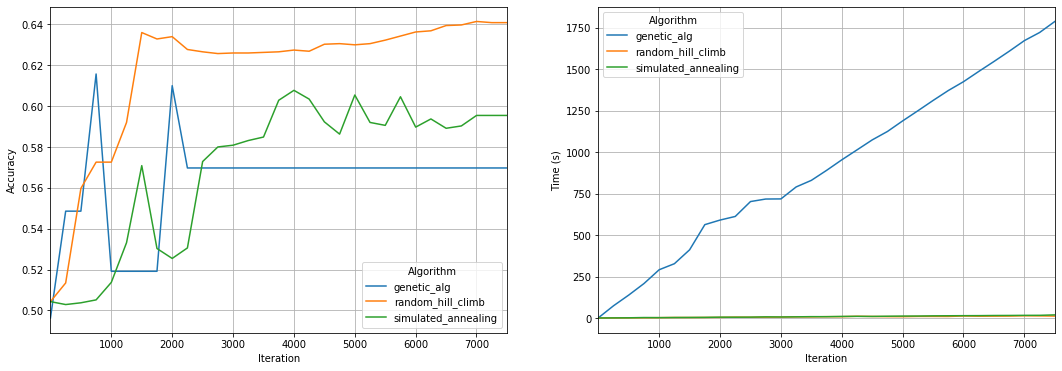

In [20]:
# Plot randomized optimization algorithm performance
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18,6))
nn_results.pivot(index='Iteration', columns='Algorithm', values='Y_Train_Acc').plot(kind='line', ax=ax)
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.grid(True)
nn_results.pivot(index='Iteration', columns='Algorithm', values='Runtime').plot(kind='line', ax=ax2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Time (s)')
ax2.grid(True)

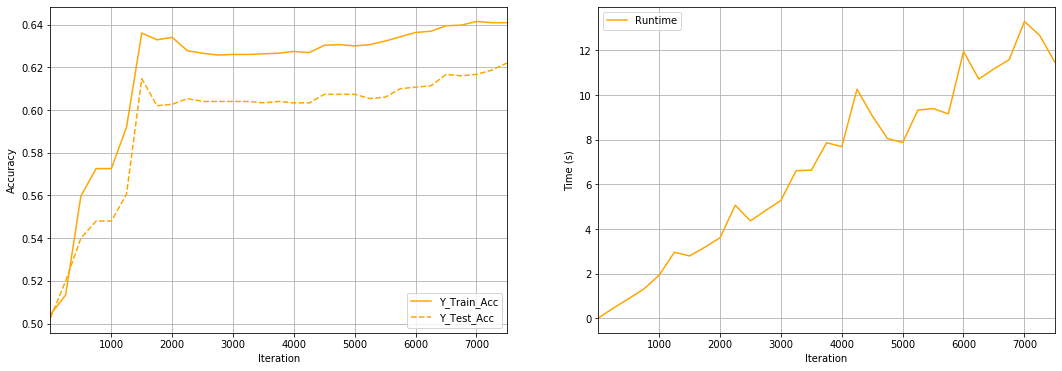

In [41]:
# Plot RHC Testing Accuracy and Training Time
rhc_data = nn_results.copy()
filter = rhc_data['Algorithm']=='random_hill_climb'
rhc_data.where(filter, inplace=True)
rhc_data.dropna(inplace=True)

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18,6))
rhc_data.plot(x='Iteration', y='Y_Train_Acc',kind='line',ax=ax, color = 'orange', linestyle = '-')
rhc_data.plot(x='Iteration', y='Y_Test_ACC',kind='line', ax=ax, label='Y_Test_Acc', color = 'orange', linestyle = '--')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.grid(True)
rhc_data.plot(x='Iteration', y='Runtime',kind='line', ax=ax2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Time (s)')
ax2.grid(True)

In [50]:
rhc_Data = []
algs = ['random_hill_climb']
iters = range(1,7502, 500)

for n in iters:
    start = time.time()
    rhc_model = mlrose.NeuralNetwork(algorithm = 'random_hill_climb', bias = True,
                               early_stopping = False, learning_rate = 0.01,
                               clip_max = 5, max_attempts = 100,
                               max_iters = n, random_state = 3)
    rhc_model.fit(X_train, y_train)


    # Predict labels for train set and assess accuracy
    rhc_y_train_pred = rhc_model.predict(X_train)
    rhc_y_train_accuracy = accuracy_score(y_train, rhc_y_train_pred)
    rhc_y_train_mse = mean_squared_error(y_train, rhc_y_train_pred)

    # Predict labels for test set and assess accuracy
    rhc_y_test_pred = rhc_model.predict(X_test)
    rhc_y_test_accuracy = accuracy_score(y_test, rhc_y_test_pred)
    rhc_y_test_mse = mean_squared_error(y_test, rhc_y_test_pred)
    end = time.time() - start
    
    rhc_Data.append([n, end, rhc_y_train_accuracy, rhc_y_test_accuracy, rhc_y_train_mse, rhc_y_test_mse])
    print("Completed %s iterations for random hill climb!"%str(n))
rhc_results = pd.DataFrame(columns = ['Iteration', 'Runtime', 'Y_Train_Acc', 'Y_Test_Acc', 'Y_Train_MSE', 'Y_Test_MSE'], data = rhc_Data)

Completed 1 iterations for random hill climb!
Completed 501 iterations for random hill climb!
Completed 1001 iterations for random hill climb!
Completed 1501 iterations for random hill climb!
Completed 2001 iterations for random hill climb!
Completed 2501 iterations for random hill climb!
Completed 3001 iterations for random hill climb!
Completed 3501 iterations for random hill climb!
Completed 4001 iterations for random hill climb!
Completed 4501 iterations for random hill climb!
Completed 5001 iterations for random hill climb!
Completed 5501 iterations for random hill climb!
Completed 6001 iterations for random hill climb!
Completed 6501 iterations for random hill climb!
Completed 7001 iterations for random hill climb!
Completed 7501 iterations for random hill climb!


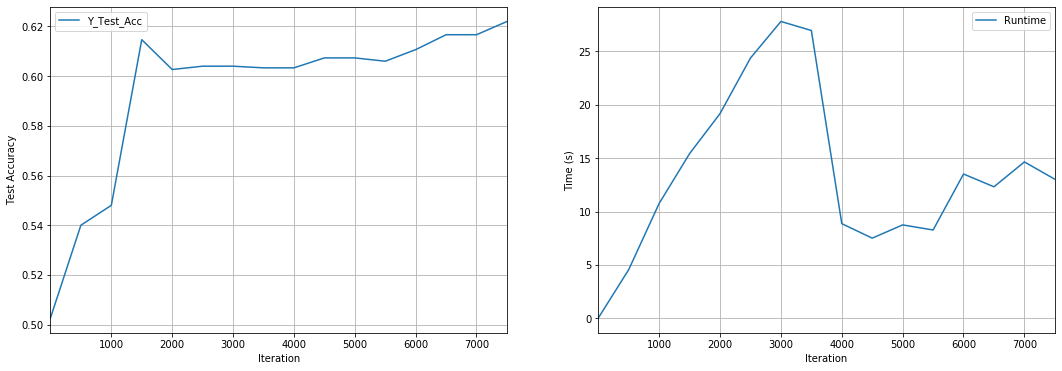

In [70]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18,6))
rhc_results.plot(x = 'Iteration', y = 'Y_Test_Acc', kind='line', ax=ax)
#ax.set_xticks(sa_results.index)
#ax.set_xticklabels(sa_results['Exponent'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Test Accuracy')
ax.grid(True)
rhc_results.plot(x = 'Iteration', y = 'Runtime', kind='line', ax=ax2)
#ax2.set_xticks(sa_results.index)
#ax2.set_xticklabels(sa_results['Exponent'])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Time (s)')
ax2.grid(True)

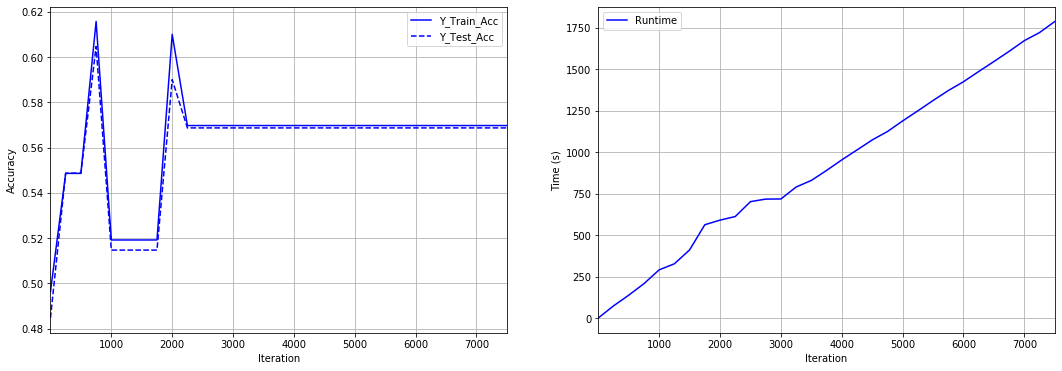

In [42]:
# Plot GA Testing Accuracy and Training Time
ga_data = nn_results.copy()
filter = ga_data['Algorithm']=='genetic_alg'
ga_data.where(filter, inplace=True)
ga_data.dropna(inplace=True)

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18,6))
ga_data.plot(x='Iteration', y='Y_Train_Acc',kind='line',ax=ax, color = 'blue', linestyle = '-')
ga_data.plot(x='Iteration', y='Y_Test_ACC',kind='line', ax=ax, label='Y_Test_Acc', color = 'blue', linestyle = '--')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.grid(True)
ga_data.plot(x='Iteration', y='Runtime',kind='line', ax=ax2, color = 'blue')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Time (s)')
ax2.grid(True)

In [4]:
ga_Data = []
algs = ['genetic_alg']
iters = range(1,3002, 1000)
mutation_prob = [0.05, 0.1, 0.5]
pop_size = [10, 100, 400]

for n in iters:
    for p in pop_size:
        for mp in mutation_prob:
            start = time.time()
            ga_model = mlrose.NeuralNetwork(algorithm = 'genetic_alg', pop_size = p, mutation_prob = mp, bias = True,
                                       early_stopping = False, 
                                       clip_max = 5, max_attempts = 25,
                                       max_iters = n, random_state = 3)
            ga_model.fit(X_train, y_train)


            # Predict labels for train set and assess accuracy
            ga_y_train_pred = ga_model.predict(X_train)
            ga_y_train_accuracy = accuracy_score(y_train, ga_y_train_pred)
            ga_y_train_mse = mean_squared_error(y_train, ga_y_train_pred)

            # Predict labels for test set and assess accuracy
            ga_y_test_pred = ga_model.predict(X_test)
            ga_y_test_accuracy = accuracy_score(y_test, ga_y_test_pred)
            ga_y_test_mse = mean_squared_error(y_test, ga_y_test_pred)
            end = time.time() - start
            
            label = str(str(p)+','+str(mp))
            
            ga_Data.append([n, p, mp, end, ga_y_train_accuracy, ga_y_test_accuracy, ga_y_train_mse, ga_y_test_mse, label])
            print("Completed %s iterations for %s!"%(n,label))
ga_results = pd.DataFrame(columns = ['Iteration', 'Pop_Size', 'Mutation_Prob', 'Runtime', 'Y_Train_Acc', 'Y_Test_Acc', 'Y_Train_MSE', 'Y_Test_MSE', 'Label'], data = ga_Data)

Completed 1 iterations for 10,0.05!
Completed 1 iterations for 10,0.1!
Completed 1 iterations for 10,0.5!
Completed 1 iterations for 100,0.05!
Completed 1 iterations for 100,0.1!
Completed 1 iterations for 100,0.5!
Completed 1 iterations for 400,0.05!
Completed 1 iterations for 400,0.1!
Completed 1 iterations for 400,0.5!
Completed 1001 iterations for 10,0.05!
Completed 1001 iterations for 10,0.1!
Completed 1001 iterations for 10,0.5!
Completed 1001 iterations for 100,0.05!
Completed 1001 iterations for 100,0.1!
Completed 1001 iterations for 100,0.5!
Completed 1001 iterations for 400,0.05!
Completed 1001 iterations for 400,0.1!
Completed 1001 iterations for 400,0.5!
Completed 2001 iterations for 10,0.05!
Completed 2001 iterations for 10,0.1!
Completed 2001 iterations for 10,0.5!
Completed 2001 iterations for 100,0.05!
Completed 2001 iterations for 100,0.1!
Completed 2001 iterations for 100,0.5!
Completed 2001 iterations for 400,0.05!
Completed 2001 iterations for 400,0.1!
Completed 200

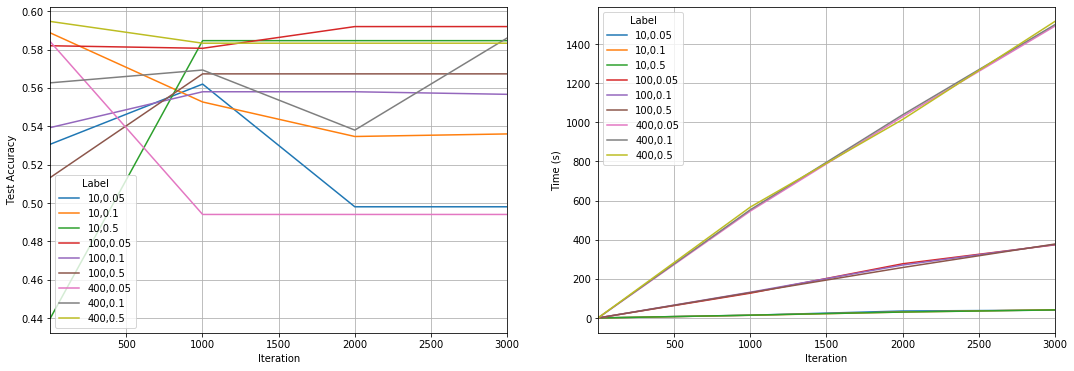

In [5]:
#ga_results = pd.DataFrame(columns = ['Iteration', 'Pop_Size', 'Mutation_Prob', 'Runtime', 'Y_Train_Acc', 'Y_Test_Acc', 'Y_Train_MSE', 'Y_Test_MSE', 'Label'], data = ga_Data)

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18,6))
ga_results.pivot(index='Iteration', columns='Label', values='Y_Test_Acc').plot(kind='line', ax=ax)
#ax.set_xticks(sa_results.index)
#ax.set_xticklabels(sa_results['Exponent'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Test Accuracy')
ax.grid(True)
ga_results.pivot(index='Iteration', columns='Label', values='Runtime').plot(kind='line', ax=ax2)
#ax2.set_xticks(sa_results.index)
#ax2.set_xticklabels(sa_results['Exponent'])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Time (s)')
ax2.grid(True)

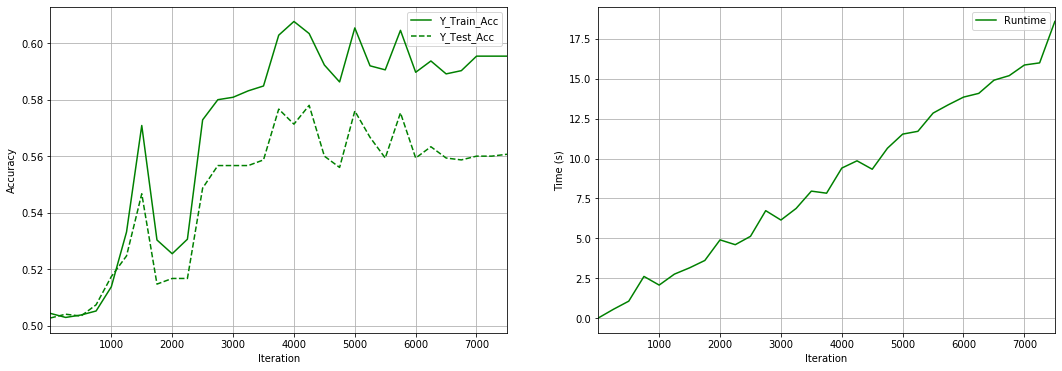

In [52]:
# Plot SA Testing Accuracy and Training Time
sa_data = nn_results.copy()
filter = sa_data['Algorithm']=='simulated_annealing'
sa_data.where(filter, inplace=True)
sa_data.dropna(inplace=True)

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18,6))
sa_data.plot(x='Iteration', y='Y_Train_Acc',kind='line',ax=ax, color='green', linestyle='-')
sa_data.plot(x='Iteration', y='Y_Test_ACC',kind='line', ax=ax, label='Y_Test_Acc', color='green', linestyle='--')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.grid(True)
sa_data.plot(x='Iteration', y='Runtime',kind='line', ax=ax2, color='green')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Time (s)')
ax2.grid(True)

In [58]:
sa_Data = []
iters = range(1,7502, 500)
exp = [0.05, 0.1, 0.25, 0.5, 0.75, 0.95]
#alg = mlrose.simulated_annealing(problem_fit, schedule = mlrose.ExpDecay(init_temp = 10, exp_const = e, min_temp =1), max_attempts = 1, init_state = None, curve = False, random_state = 2)
for n in iters:
    for e in exp:
        start = time.time()
        sa_model = mlrose.NeuralNetwork(algorithm = 'simulated_annealing', schedule = mlrose.ExpDecay(init_temp = 10, exp_const = n, min_temp =1), bias = True,
                                   learning_rate = e, early_stopping = False, 
                                   clip_max = 5, max_attempts = 100,
                                   max_iters = n, random_state = 3)
        sa_model.fit(X_train, y_train)


        # Predict labels for train set and assess accuracy
        sa_y_train_pred = sa_model.predict(X_train)
        sa_y_train_accuracy = accuracy_score(y_train, sa_y_train_pred)
        sa_y_train_mse = mean_squared_error(y_train, sa_y_train_pred)

        # Predict labels for test set and assess accuracy
        sa_y_test_pred = sa_model.predict(X_test)
        sa_y_test_accuracy = accuracy_score(y_test, sa_y_test_pred)
        sa_y_test_mse = mean_squared_error(y_test, sa_y_test_pred)
        end = time.time() - start
        
        sa_Data.append([n, e, end, sa_y_train_accuracy, sa_y_test_accuracy, sa_y_train_mse, sa_y_test_mse])
        print("Completed %s iterations for cooling exponent: %s!"%(n,e))
sa_results = pd.DataFrame(columns = ['Iteration', 'Exponent', 'Runtime', 'Y_Train_Acc', 'Y_Test_Acc', 'Y_Train_MSE', 'Y_Test_MSE'], data = sa_Data)

Completed 1 iterations for cooling exponent: 0.05!
Completed 1 iterations for cooling exponent: 0.1!
Completed 1 iterations for cooling exponent: 0.25!
Completed 1 iterations for cooling exponent: 0.5!
Completed 1 iterations for cooling exponent: 0.75!
Completed 1 iterations for cooling exponent: 0.95!
Completed 501 iterations for cooling exponent: 0.05!
Completed 501 iterations for cooling exponent: 0.1!
Completed 501 iterations for cooling exponent: 0.25!
Completed 501 iterations for cooling exponent: 0.5!
Completed 501 iterations for cooling exponent: 0.75!
Completed 501 iterations for cooling exponent: 0.95!
Completed 1001 iterations for cooling exponent: 0.05!
Completed 1001 iterations for cooling exponent: 0.1!
Completed 1001 iterations for cooling exponent: 0.25!
Completed 1001 iterations for cooling exponent: 0.5!
Completed 1001 iterations for cooling exponent: 0.75!
Completed 1001 iterations for cooling exponent: 0.95!
Completed 1501 iterations for cooling exponent: 0.05!
Comp

In [61]:
sa_results.head(10)

,Iteration,Exponent,Runtime,Y_Train_Acc,Y_Test_Acc,Y_Train_MSE,Y_Test_MSE
0,1,0.05,0.032077,0.504286,0.502667,0.495714,0.497333
1,1,0.10,0.005021,0.504286,0.502667,0.495714,0.497333
2,1,0.25,0.011029,0.503714,0.501333,0.496286,0.498667
3,1,0.50,0.005810,0.503714,0.502000,0.496286,0.498000
4,1,0.75,0.008021,0.503429,0.502000,0.496571,0.498000
5,1,0.95,0.018492,0.503429,0.502000,0.496571,0.498000
6,501,0.05,1.246319,0.503429,0.502667,0.496571,0.497333
7,501,0.10,1.218902,0.528571,0.534000,0.471429,0.466000
8,501,0.25,1.284045,0.568286,0.563333,0.431714,0.436667
9,501,0.50,1.214190,0.585143,0.574667,0.414857,0.425333


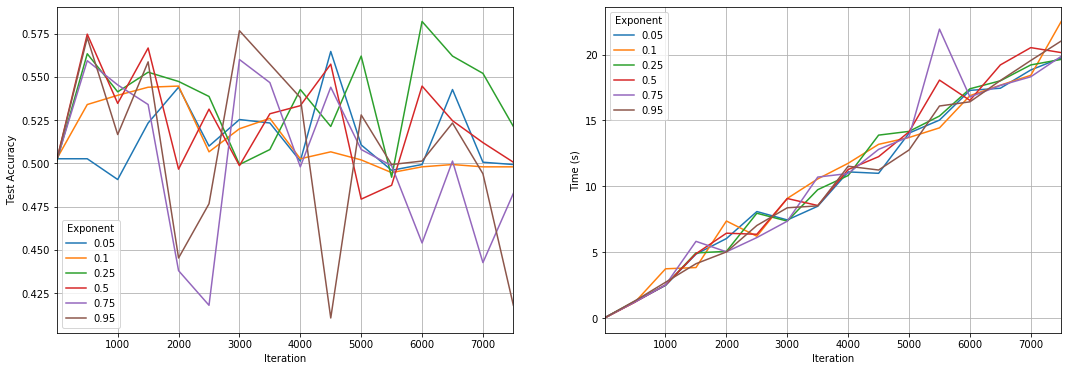

In [73]:
#sa_results = pd.DataFrame(columns = ['Iteration', 'Exponent', 'Runtime', 'Y_Train_Acc', 'Y_Test_Acc', 'Y_Train_MSE', 'Y_Test_MSE'], data = sa_Data)

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18,6))
sa_results.pivot(index='Iteration', columns='Exponent', values='Y_Test_Acc').plot(kind='line', ax=ax)
#ax.set_xticks(sa_results.index)
#ax.set_xticklabels(sa_results['Exponent'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Test Accuracy')
ax.grid(True)
sa_results.pivot(index='Iteration', columns='Exponent', values='Runtime').plot(kind='line', ax=ax2)
#ax2.set_xticks(sa_results.index)
#ax2.set_xticklabels(sa_results['Exponent'])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Time (s)')
ax2.grid(True)